In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [8]:
#load data
df = pd.read_csv('spotify_2023.csv',encoding='latin-1')
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [9]:
#Coverting streams and in_deezer_playlists into float
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'], errors='coerce')

#replace commas in in_shazam_charts so it's possible to convert it into int
df['in_shazam_charts'] = df['in_shazam_charts'].str.replace(',', '', regex=True).astype(float)

In [10]:
# missing values
missing_values = df.isnull().sum()
print(missing_values)

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  1
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists     79
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64


In [11]:
# delete rows with missing values for 'key' and 'streams' to maintain the integrity and quality of dataset
# because we think these values are very important for the prediction
df = df.dropna(subset=['key'])
df = df.dropna(subset=['streams'])

In [12]:
missing_values = df.isnull().sum()
print(missing_values)

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists     75
in_deezer_charts         0
in_shazam_charts        41
bpm                      0
key                      0
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64


In [13]:
df = df.fillna(-1)
missing_values = df.isnull().sum()
print(missing_values)

track_name              0
artist(s)_name          0
artist_count            0
released_year           0
released_month          0
released_day            0
in_spotify_playlists    0
in_spotify_charts       0
streams                 0
in_apple_playlists      0
in_apple_charts         0
in_deezer_playlists     0
in_deezer_charts        0
in_shazam_charts        0
bpm                     0
key                     0
mode                    0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%          0
instrumentalness_%      0
liveness_%              0
speechiness_%           0
dtype: int64


In [14]:
df['streams'] = df['streams'].astype('int64')
df['in_deezer_playlists'] = df['in_deezer_playlists'].astype('int64')
df['in_shazam_charts'] = df['in_shazam_charts'].astype('int64')

In [15]:
# Combine 'released_year', 'released_month', and 'released_day' into a single datetime column
df['release_date'] = pd.to_datetime(df['released_year'].astype(str) + '-' +
                                      df['released_month'].astype(str) + '-' +
                                      df['released_day'].astype(str), errors='coerce')

# Check the new 'release_date' column
print(df['release_date'].head())

0   2023-07-14
1   2023-03-23
2   2023-06-30
3   2019-08-23
4   2023-05-18
Name: release_date, dtype: datetime64[ns]


In [16]:
# One-Hot Encoding for 'mode', keep the original 'mode' column untouched
mode_encoded = pd.get_dummies(df['mode'], prefix='mode')

# concat one-hot encoded df to main df
df = pd.concat([df, mode_encoded], axis=1)

In [17]:
# new column for encoded 'key'
df['key_encoded'] = LabelEncoder().fit_transform(df['key'].astype(str))

# check encoded values
print(df[['mode', *mode_encoded.columns, 'key', 'key_encoded']].head(10))

    mode  mode_Major  mode_Minor key  key_encoded
0  Major           1           0   B            2
1  Major           1           0  C#            3
2  Major           1           0   F            7
3  Major           1           0   A            0
4  Minor           0           1   A            0
5  Major           1           0  C#            3
6  Minor           0           1   F            7
7  Major           1           0   F            7
8  Minor           0           1  C#            3
9  Minor           0           1   D            4


In [18]:
df['danceability_%'] = df['danceability_%'] / 100.0
df['valence_%'] = df['valence_%'] / 100.0
df['energy_%'] = df['energy_%'] / 100.0
df['acousticness_%'] = df['acousticness_%'] / 100.0
df['instrumentalness_%'] = df['instrumentalness_%'] / 100.0
df['liveness_%'] = df['liveness_%'] / 100.0
df['speechiness_%'] = df['speechiness_%'] / 100.0

In [19]:
columns_to_use = [
    'artist_count', 'released_year', 'released_month', 'released_day',
    'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts',
    'in_deezer_playlists', 'in_deezer_charts', 'bpm', 'danceability_%',
    'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%',
    'liveness_%', 'speechiness_%', 'key_encoded'
]

# Split the data into train-validation-test sets
X = df[columns_to_use]
y = df['streams']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
import xgboost as xgb

# Convert data to DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify XGBoost parameters for regression
params = {
    'objective': 'reg:squarederror',  # for regression tasks
    'eval_metric': 'rmse',              # root mean squared error as the evaluation metric
    'max_depth': 7,                    # maximum depth of a tree
    'eta': 1,                        # learning rate
}

# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = xgb_model.predict(dtest)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming y_test is the true target values and y_pred_rescaled is the predicted values

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# R-squared (R2) Score
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2) Score: {r2}')

Mean Absolute Error (MAE): 198703167.75581396
Mean Squared Error (MSE): 1.2206149448385274e+17
Root Mean Squared Error (RMSE): 349373001.9389774
R-squared (R2) Score: 0.7531146405190846


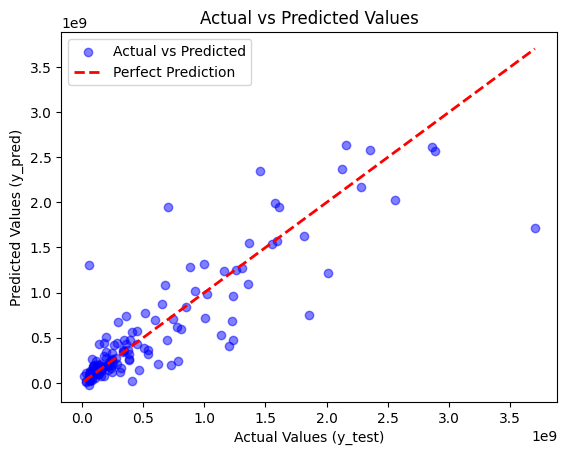

In [32]:
import matplotlib.pyplot as plt

# Assuming y_test_ is your rescaled actual values and y_pred_rescaled is your rescaled predicted values
plt.scatter(y_test, y_pred, alpha=0.5, c='blue', label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.legend()
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'eta': 0.1, 'max_depth': 3}
Best R-squared Score: 0.8176737186119591


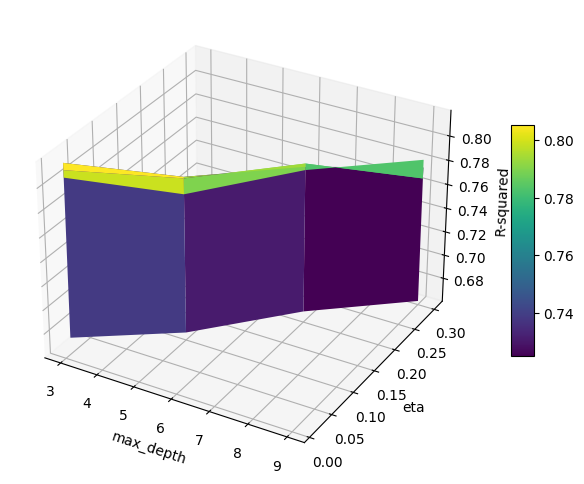

In [36]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

columns_to_use = [
    'artist_count', 'released_year', 'released_month', 'released_day',
    'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts',
    'in_deezer_playlists', 'in_deezer_charts', 'bpm', 'danceability_%',
    'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%',
    'liveness_%', 'speechiness_%', 'key_encoded'
]

# Split the data into train-validation-test sets
X = df[columns_to_use]
y = df['streams']

# Split the data into train-validation-test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify a range of hyperparameters for grid search
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'eta': [0.01, 0.1, 0.2, 0.3]
}

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='r2', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Extract results
results = grid_search.cv_results_
max_depth_values = param_grid['max_depth']
eta_values = param_grid['eta']
r2_scores = results['mean_test_score'].reshape(len(max_depth_values), len(eta_values))

# Find the best hyperparameters
best_params = grid_search.best_params_
best_r2_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best R-squared Score:", best_r2_score)

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('max_depth')
ax.set_ylabel('eta')
ax.set_zlabel('R-squared')

# Plot the surface
surface = ax.plot_surface(max_depth_values, eta_values, r2_scores, cmap='viridis')

# Add a colorbar
colorbar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)

# Show the plot
plt.show()

In [37]:
# Train the model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', **best_params)
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
r2_test = best_xgb_model.score(X_test, y_test)

print(f'Test Set Metrics:')
print(f'Mean Squared Error (MSE): {mse_test}')
print(f'Root Mean Squared Error (RMSE): {rmse_test}')
print(f'R-squared (R2) Score: {r2_test}')


Test Set Metrics:
Mean Squared Error (MSE): 7.86141544511201e+16
Root Mean Squared Error (RMSE): 280382157.8687205
R-squared (R2) Score: 0.840992576209031


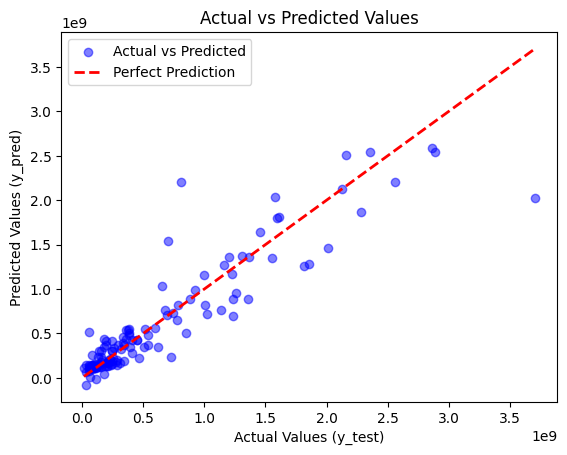

In [38]:
import matplotlib.pyplot as plt

# Assuming y_test_ is your rescaled actual values and y_pred_rescaled is your rescaled predicted values
plt.scatter(y_test, y_pred, alpha=0.5, c='blue', label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.legend()
plt.show()

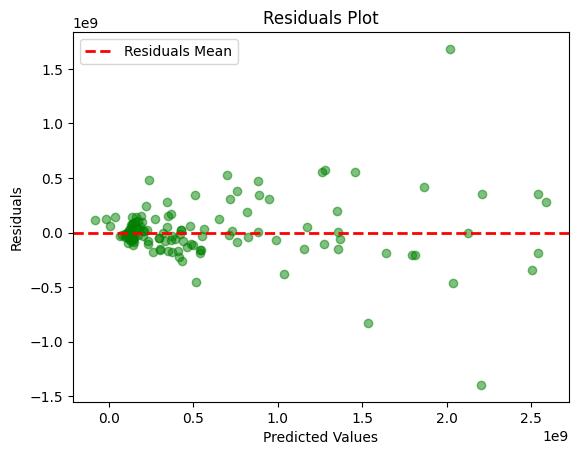

In [42]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5, c='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Residuals Mean')
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

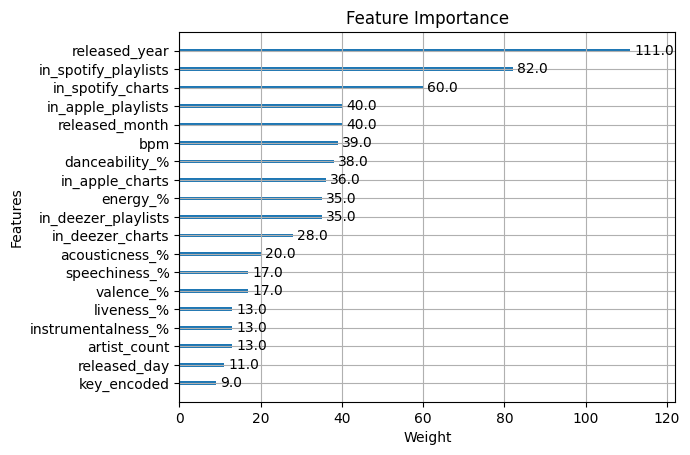

In [44]:
xgb.plot_importance(best_xgb_model, importance_type='weight', xlabel='Weight', ylabel='Features', title='Feature Importance')
plt.show()


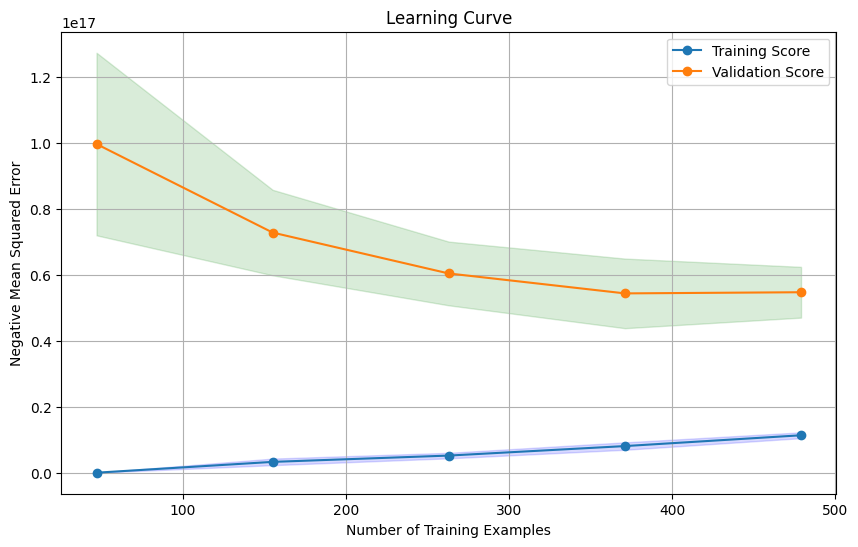

In [48]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Assuming you have your XGBoost model (xgb_model) and training data (X_train, y_train)

# Create a learning curve
train_sizes, train_scores, test_scores = learning_curve(best_xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation of training and test scores
train_mean = -train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = -test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, label='Validation Score', marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')

plt.title('Learning Curve')
plt.xlabel('Number of Training Examples')
plt.ylabel('Negative Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.show()
